In [26]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad

In [27]:
import muon as mu

In [28]:
from muon import atac as ac

In [29]:
######## ATAC Modality

In [30]:
mdata1 = mu.read("/Users/pfb2024/pfb_project/PFB-LOLA-seq/MA8.h5mu/")

/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [31]:
mdata1

MuData object with n_obs × n_vars = 5059 × 96938
  var:	'gene_ids', 'feature_types', 'genome', 'interval'
  2 modalities
    rna:	4132 x 23843
      obs:	'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'percent_ribo'
      var:	'gene_ids', 'feature_types', 'genome', 'interval', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    atac:	5059 x 73095
      var:	'gene_ids', 'feature_types', 'genome', 'interval'
      uns:	'files'

In [32]:
atac = mdata1.mod['atac']
rna = mdata1.mod['rna']

In [33]:
atac.X.shape

(5059, 73095)

In [34]:
#QC

In [35]:
sc.pp.calculate_qc_metrics(atac, percent_top=None, log1p=False, inplace=True)

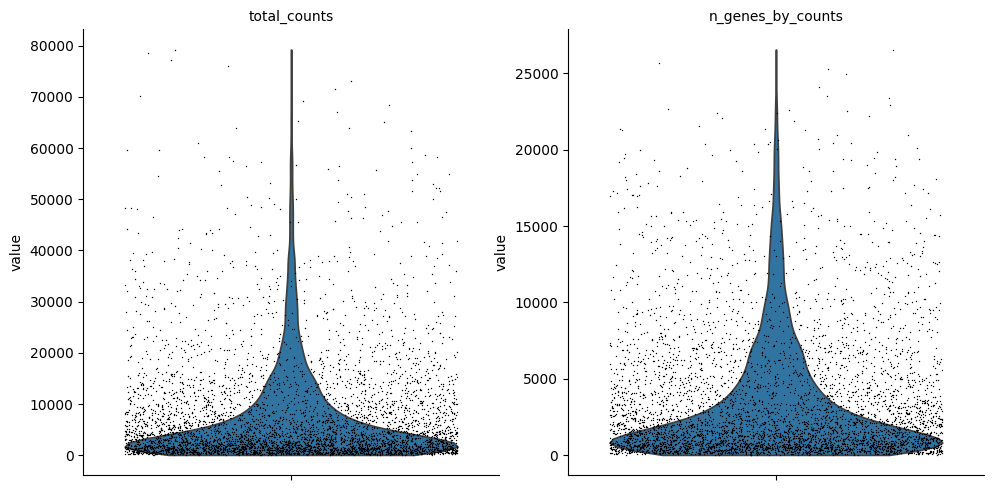

In [36]:
sc.pl.violin(atac, ['total_counts', 'n_genes_by_counts'], jitter=0.4, multi_panel=True)

In [37]:
mu.pp.filter_var(atac, 'n_cells_by_counts', lambda x: x >= 3)

In [38]:
mu.pp.filter_obs(atac, 'n_genes_by_counts', lambda x: (x >= 200) & (x <= 4000))
# This is analogous to
#   sc.pp.filter_cells(atac, max_genes=15000)
#   sc.pp.filter_cells(atac, min_genes=2000)
# but does in-place filtering avoiding copying the object

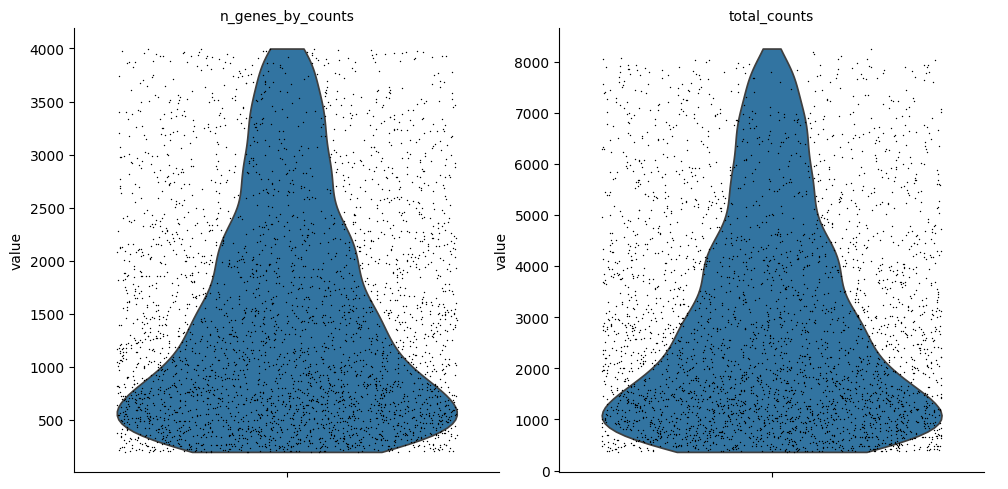

In [39]:
sc.pl.violin(atac, ['n_genes_by_counts', 'total_counts'], jitter=0.4, multi_panel=True)

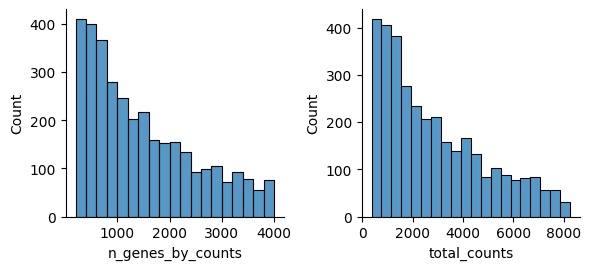

In [40]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'])

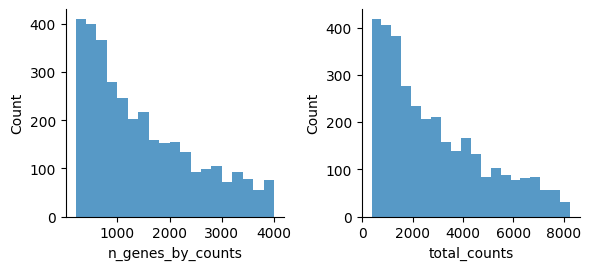

In [41]:
mu.pl.histogram(atac, ['n_genes_by_counts', 'total_counts'], linewidth=0)

In [42]:
#ATAC specific QC

In [43]:
atac.obs['NS']=1

Fetching Regions...: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


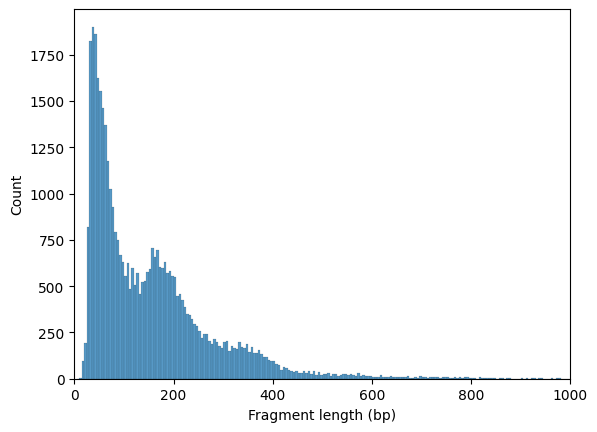

In [44]:
ac.pl.fragment_histogram(atac, region='chr1:1-2000000')

In [45]:
ac.tl.nucleosome_signal(atac, n=1e6)

Reading Fragments: 100%|██████████| 1000000/1000000 [00:03<00:00, 296322.09it/s]


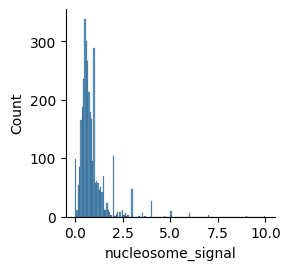

In [46]:
mu.pl.histogram(atac, "nucleosome_signal", kde=False)

In [47]:
#TSS enrichment

In [52]:
ac.tl.get_gene_annotation_from_rna(mdata1['rna']).head(10)  # accepts MuData with 'rna' modality or mdata['rna'] AnnData directly

,Chromosome,Start,End,gene_id,gene_name
AL627309.1,chr1,120931,133723,ENSG00000238009,AL627309.1
AL627309.5,chr1,149706,173862,ENSG00000241860,AL627309.5
AL669831.2,chr1,760910,760911,ENSG00000229905,AL669831.2
LINC01409,chr1,778757,803934,ENSG00000237491,LINC01409
LINC01128,chr1,827597,860227,ENSG00000228794,LINC01128
LINC00115,chr1,827521,827522,ENSG00000225880,LINC00115
FAM41C,chr1,870200,876903,ENSG00000230368,FAM41C
AL645608.6,chr1,904833,904834,ENSG00000272438,AL645608.6
AL645608.2,chr1,911434,911435,ENSG00000230699,AL645608.2
LINC02593,chr1,919691,919692,ENSG00000223764,LINC02593


In [54]:
tss = ac.tl.tss_enrichment(mdata1, n_tss=1000)  # by default, features=ac.tl.get_gene_annotation_from_rna(mdata)

Fetching Regions...: 100%|██████████| 1000/1000 [00:03<00:00, 260.04it/s]
/Users/pfb2024/.local/lib/python3.12/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [55]:
tss

AnnData object with n_obs × n_vars = 3390 × 2001
    obs: 'n_genes_by_counts', 'total_counts', 'NS', 'nucleosome_signal', 'tss_score'
    var: 'TSS_position'

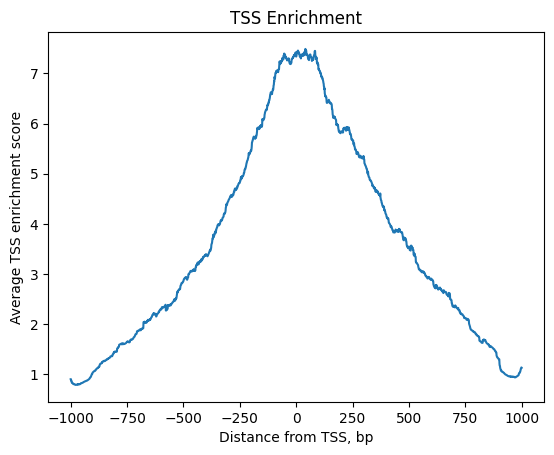

In [56]:
ac.pl.tss_enrichment(tss)

In [57]:
#Normalisation

In [58]:
# Save original counts
atac.layers["counts"] = atac.X

In [59]:
sc.pp.normalize_per_cell(atac, counts_per_cell_after=1e4)
sc.pp.log1p(atac)

In [60]:
#Feature selection 
#We will label highly variable peaks that we’ll use for downstream analysis.

In [61]:
sc.pp.highly_variable_genes(atac, min_mean=0.05, max_mean=1.5, min_disp=.5)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


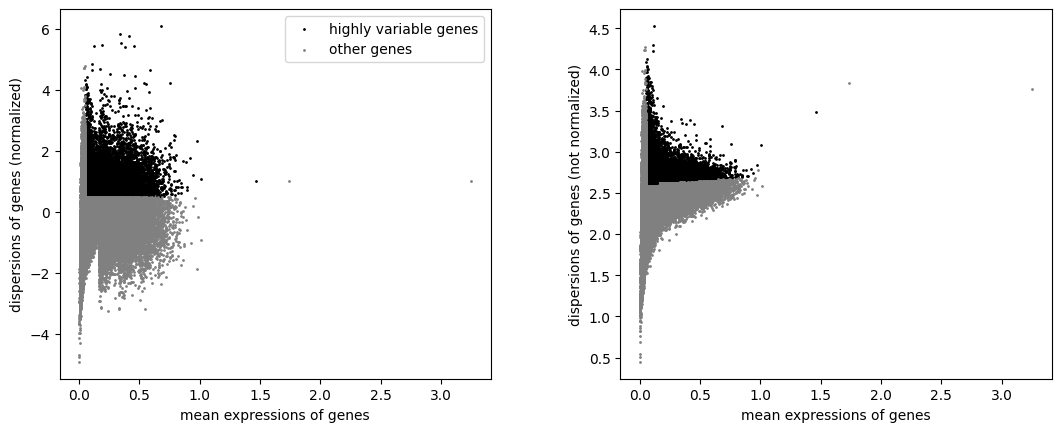

In [62]:
sc.pl.highly_variable_genes(atac)

In [63]:
np.sum(atac.var.highly_variable)

np.int64(15752)

In [64]:
#Scaling

In [65]:
#TF-IDF normalization did not work previously but this step does TF-IDF counts for getting latent components. Apparenlty , this works!

In [66]:
atac.raw = atac

In [67]:
ac.tl.lsi(atac)

In [68]:
atac.obsm['X_lsi'] = atac.obsm['X_lsi'][:,1:]
atac.varm["LSI"] = atac.varm["LSI"][:,1:]
atac.uns["lsi"]["stdev"] = atac.uns["lsi"]["stdev"][1:]

In [69]:
sc.pp.neighbors(atac, use_rep="X_lsi", n_neighbors=10, n_pcs=30)

In [70]:
#PCA plots ATAC

In [71]:
sc.pp.scale(atac)
sc.tl.pca(atac)

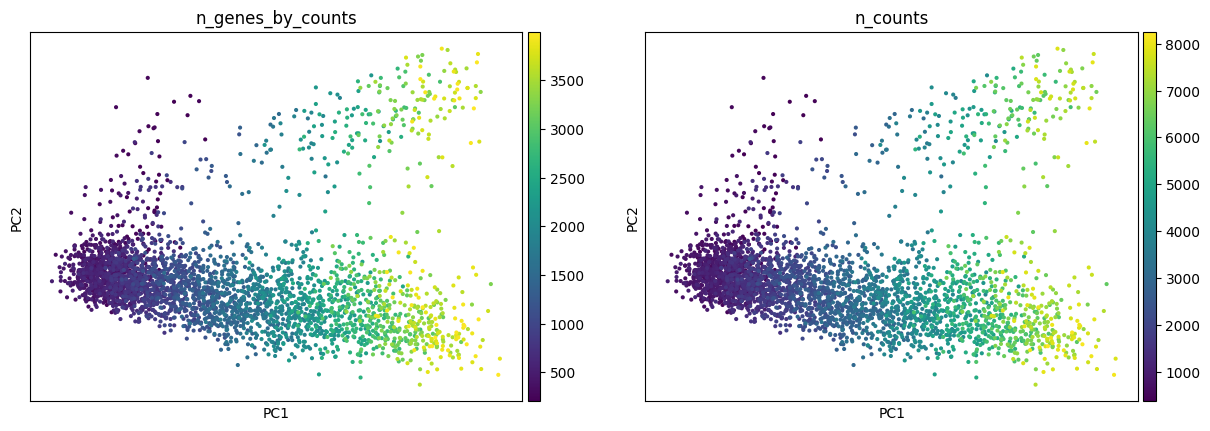

In [72]:
sc.pl.pca(atac, color=["n_genes_by_counts", "n_counts"])

In [73]:
ac.tl.add_peak_annotation(atac, annotation="/Users/pfb2024/pfb_project/PFB-LOLA-seq/atac_peak_annotation.tsv")

/Users/pfb2024/Library/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/muon/_atac/tools.py:118: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pa.loc[pa.distance.isnull(), "distance"] = ""


In [74]:
atac.uns['atac']['peak_annotation'].tail()

,peak,distance,peak_type
gene,,,
VAMP7,chrY:56876314-56876418,191447,distal
VAMP7,chrY:56877388-56877968,189897,distal
VAMP7,chrY:56879537-56880497,187368,distal
VAMP7,chrY:56881488-56881665,186200,distal
VAMP7,chrY:56885563-56885700,182165,distal


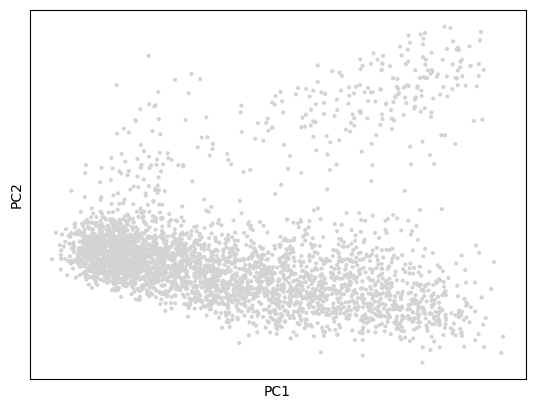

In [75]:
ac.pl.pca(atac, color=None, average="total")

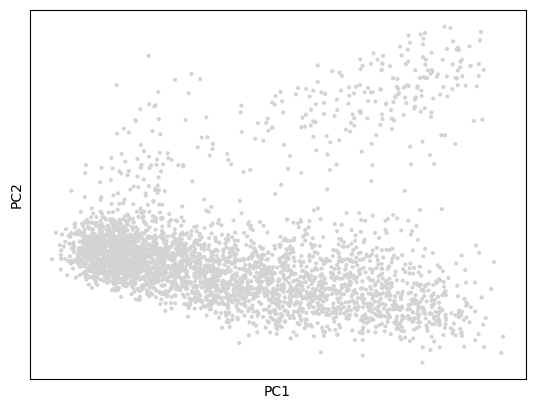

In [76]:
ac.pl.pca(atac, color=None, average="peak_type")

In [77]:
sc.pp.neighbors(atac, n_neighbors=10, n_pcs=30)

In [78]:
#Non-linear dimensionality reduciton and clustering

In [79]:
sc.tl.leiden(atac, resolution=.5)

/var/folders/j0/6b9x3l9n5nzgmbj9pcz255xc0000gq/T/ipykernel_14947/937485634.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(atac, resolution=.5)


In [80]:
sc.tl.umap(atac, spread=1.5, min_dist=.5, random_state=20)

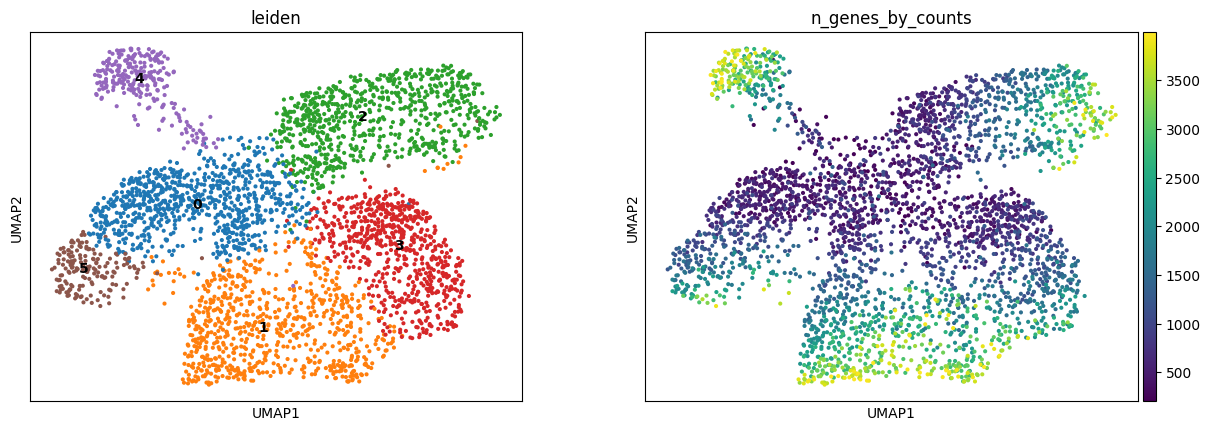

In [81]:
sc.pl.umap(atac, color=["leiden", "n_genes_by_counts"], legend_loc="on data")

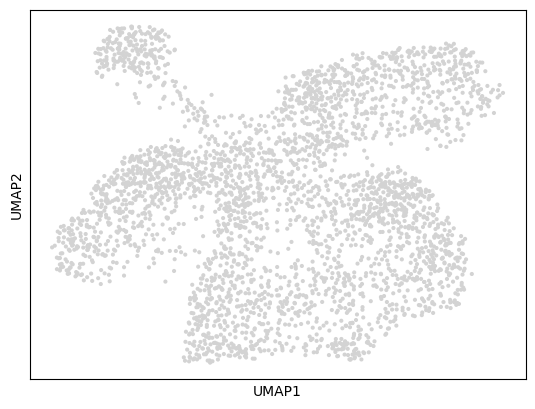

In [82]:
ac.pl.umap(atac, color=None, average="peak_type")

In [83]:
#Marker genes and cell types

In [84]:
ac.tl.rank_peaks_groups(atac, 'leiden', method='t-test')

In [93]:
result = atac.uns['rank_genes_groups']
groups = result['names'].dtype.names
# pd.set_option("styler.render.max_columns", 50)
# pd.DataFrame(
#     {group + '_' + key[:1]: result[key][group]
#     for group in groups for key in ['names', 'genes', 'pvals']}).head(10)

In [95]:
new_cluster_names = {
    "0": "A", "1": "B", "2": "C",
    "3": "D", "4": "E", 
    "5": "F"
}

atac.obs['celltype'] = atac.obs.leiden.astype("str").values
atac.obs.celltype = atac.obs.celltype.astype("category").cat.rename_categories(new_cluster_names)

In [97]:
import matplotlib
import matplotlib.pyplot as plt

cmap = plt.get_cmap('rainbow')
colors = cmap(np.linspace(0, 1, len(atac.obs.celltype.cat.categories)))

atac.uns["celltype_colors"] = list(map(matplotlib.colors.to_hex, colors))

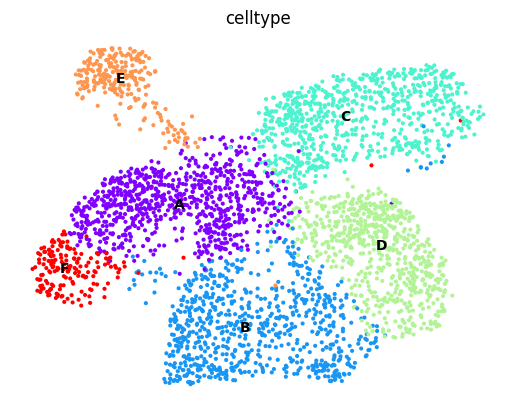

In [98]:
sc.pl.umap(atac, color="celltype", legend_loc="on data", frameon=False)

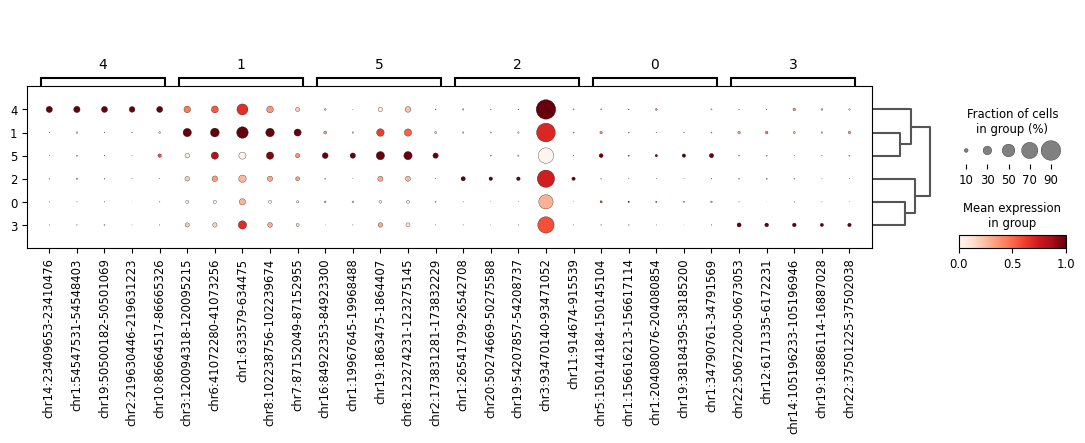

In [99]:
sc.tl.rank_genes_groups(atac, groupby="leiden", method="wilcoxon", n_genes = 40, )
sc.pl.rank_genes_groups_dotplot(
    atac, groupby="leiden", standard_scale="var", n_genes=5
)

In [100]:
mu.write("/Users/pfb2024/pfb_project/PFB-LOLA-seq/MA8.h5mu/atac", atac)